<a href="https://colab.research.google.com/github/aryannuka/data-science/blob/main/U5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unit 5 Project: Assists vs Age in Basketball

In [ ]:
!pip install pymc

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

In this project I'm using basketball data to analyze the correlation between number of assists compared to the age of professional nba players.

In [ ]:
#load the data into a pandas dataframe, and print it
url_bsktbl = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
bsktbl = pd.read_csv(url_bsktbl)

In [ ]:
bsktbl

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


In [ ]:
#numpy array of the two positions, but
ages = bsktbl['Age'].values

#makes a numpy array of the assist values
assists = bsktbl['AST'].values

#here I normalize the assist values.
#This makes it easier for pymc to process
assists_normalized = assists - assists.mean()

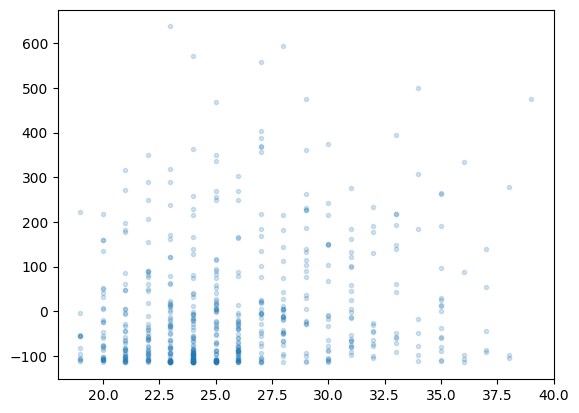

In [ ]:
plt.scatter(ages, assists_normalized, marker=".", alpha=0.2)

In order to clearly view my data in a different form that shows the trend better, I separated the data that I needed to create a new dataset to only include the assists and age from the whole basketball data.

In [ ]:
data = pd.DataFrame({'Assists': bsktbl['AST'].astype(int), 'Age': bsktbl['Age']})

In [ ]:
data

,Assists,Age
0,97,24
1,278,26
2,83,23
3,138,23
4,204,25
...,...,...
567,57,35
568,583,25
569,29,25
570,39,31


<Axes: xlabel='Assists', ylabel='Age'>

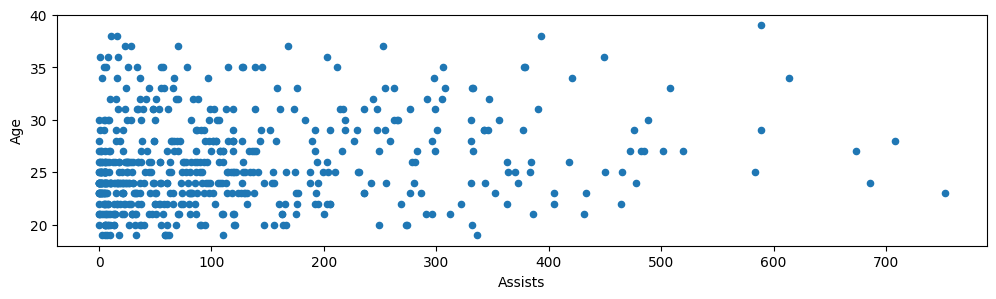

In [ ]:
data.plot(x="Assists", y="Age", figsize=(12, 3), kind="scatter")

In [ ]:
with pm.Model() as model_nbb:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)

    #the linear part of our model,
    #but with a twist:
    #our line is exponentiated, in order to make our all our values positive
    μ = pm.Deterministic("μ", pm.math.exp(α + β * data.Assists))

    #prior for the likelihood's standard deviation
    σ = pm.HalfNormal("σ", 10)

    #likelihood
    y_pred = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=data.Age)

    idata_nbb = pm.sample()

Output()

Output()

In [ ]:
pm.sample_posterior_predictive(idata_nbb, model = model_nbb, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

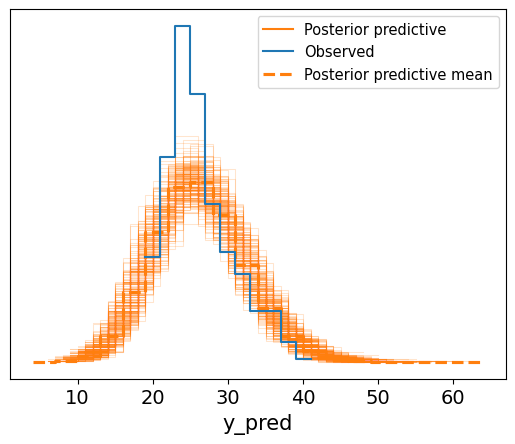

In [ ]:
az.plot_ppc(idata_nbb, num_pp_samples=200, colors=["C1", "C0", "C1"])

The Negative Binomial distribution was the best choice for modeling count data, such as the number of assists, because it captures the extra variability in the data. Unlike other distributions like Poisson or Normal, which assume equal variance and mean, the Negative Binomial distribution allows overdispersion, making it a more accurate fit for real-world data. This makes it an ideal choice for modeling the relationship between number of assists vs age. Also, since I'm predicting age, and assists which are always positive, Negative Bionomial works for best for this and we can see from the ppc that all predictions are positive as expected.

Text(0, 0.5, 'Player Age')

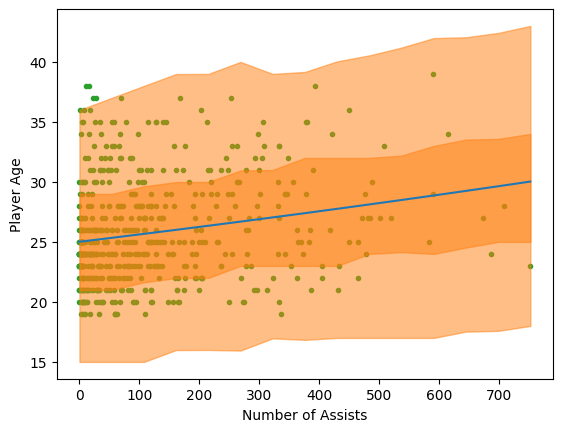

In [ ]:
mean_line = idata_nbb.posterior["μ"].mean(("chain", "draw"))
assists = np.random.normal(data.Assists.values, 0.01)
idx = np.argsort(assists)
x = np.linspace(assists.min(), assists.max(), 15)
y_pred_q = idata_nbb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(assists[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(data.Assists, data.Age, "C2.", zorder=-3)
mean_line_x = np.interp(x, assists[idx], mean_line[idx])
ax.plot(x, mean_line_x, c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("Number of Assists")
ax.set_ylabel("Player Age")


The data for assists vs age in this case is not highly correlated but the best fit above looks right for the data because it starts around the median of the cluster at 0 assists and then goes up with age as we can see number of assists going up with age in general. Next time, I could make this better by including  a certain position(such as point guard or power forward) of a player with regards to age and assists to better see how the age affects the number of assists, as this number varies from position to position in basketball, as not all positions require the player to make as many assists.